In [84]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from neurophox.ml.nonlinearities import cnormsq
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [96]:
from utils_mnist import *
import matplotlib as mpl
epochs = 500
batch_size = 512
N_classes = 10
mnist_dp = MNISTDataProcessor()
data_N16 = mnist_dp.fourier(2)

In [97]:
# # first direction
# def construct_onn_EO_tf(N,
#                         N_classes=10,
#                         L=2,
#                         train_alpha=False,
#                         train_g=False,
#                         train_phi_b=False,
#                         single_param_per_layer=True,
#                         theta_init_name='haar_rect',
#                         phi_init_name='random_phi',
#                         alpha=0.1,
#                         g=0.05*np.pi,
#                         phi_b=1*np.pi):
#     '''
#     Constructs an L layer EO ONN model with the specified alpha, g, and phi_b
    
#     The parameters alpha, g, and phi_b can be scalars or vectors. If scalar-valued, the value is used
#     for all L layers. If vector-valued, the length must be equal to L and each vector element is used 
#     for the corresponding layer.
#     '''
#     alpha = np.asarray(alpha)
#     g     = np.asarray(g)
#     phi_b = np.asarray(phi_b)
    
#     if alpha.size == 1:
#         alpha = np.tile(alpha, L)
#     else:
#         assert alpha.size == L, 'alpha has a size which is inconsistent with L'
    
#     if g.size == 1:
#         g = np.tile(g, L)
#     else:
#         assert g.size == L, 'g has a size which is inconsistent with L'
    
#     if phi_b.size == 1:
#         phi_b = np.tile(phi_b, L)
#     else:
#         assert phi_b.size == L, 'phi_b has a size which is inconsistent with L'
    
#     layers=[]
#     for i in range(L):
#         layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
#         layers.append(EOIntensityModulation(N,
#                                             alpha[i],
#                                             g[i],
#                                             phi_b[i],
#                                             train_alpha=train_alpha,
#                                             train_g=train_g,
#                                             train_phi_b=train_phi_b,
#                                             single_param_per_layer=single_param_per_layer))
    
#     layers.append(Activation(cnormsq))
#     layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
#     model = tf.keras.models.Sequential(layers)
    
#     return model

In [98]:
mnist_dp = MNISTDataProcessor()
data_N16 = mnist_dp.fourier(2)

In [99]:
# second direction
from neurophox.ml.nonlinearities import cnormsq
def res_identity(N,
                 N_classes=10,
                 L=2,
                 train_alpha=False,
                 train_g=False,
                 train_phi_b=False,
                 single_param_per_layer=True,
                 theta_init_name='haar_rect',
                 phi_init_name='random_phi',
                 alpha=0.1,
                 g=0.05*np.pi,
                 phi_b=1*np.pi): 
    
    # Step 1 (Setup Input Layer)
    size_input = (N,)
    x_input = tf.keras.layers.Input(size_input)
    x = tf.complex(x_input, tf.zeros_like(x_input))
#     print(type(x))
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added
    x_skip = x # this will be used for addition with the residual block
    # parameters replicate
    alpha = np.asarray(alpha)
    g     = np.asarray(g)
    phi_b = np.asarray(phi_b)
    
    if alpha.size == 1:
        alpha = np.tile(alpha, L)
    else:
        assert alpha.size == L, 'alpha has a size which is inconsistent with L'
    
    if g.size == 1:
        g = np.tile(g, L)
    else:
        assert g.size == L, 'g has a size which is inconsistent with L'
    
    if phi_b.size == 1:
        phi_b = np.tile(phi_b, L)
    else:
        assert phi_b.size == L, 'phi_b has a size which is inconsistent with L'
    

    #first block 
    x = RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name)(x)
    x = EOIntensityModulation(N,
                              alpha,
                              g,
                              phi_b,
                              train_alpha=train_alpha,
                              train_g=train_g,
                              train_phi_b=train_phi_b,
                              single_param_per_layer=single_param_per_layer)(x)
    x = Add()([x, x_skip])
    
    #second block 
    x_skip2 = x
    x = RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name)(x)
    x = EOIntensityModulation(N,
                              alpha,
                              g,
                              phi_b,
                              train_alpha=train_alpha,
                              train_g=train_g,
                              train_phi_b=train_phi_b,
                              single_param_per_layer=single_param_per_layer)(x)   
    # add the input 
    x = Add()([x, x_skip2])
    
    
    x = Activation(cnormsq)(x)
    x = tf.math.real(x[:, :N_classes])
    model = Model(inputs=x_input, outputs=x, name='res_identity')

    return model

In [100]:
# The ONN with the electro-optic activation function
model_res_N16 = res_identity(16, L=1)
model_res_N16.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [101]:
model_res_N16.summary()

Model: "res_identity"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
tf.zeros_like_12 (TFOpLambda)   (None, 16)           0           input_16[0][0]                   
__________________________________________________________________________________________________
tf.dtypes.complex_13 (TFOpLambd (None, 16)           0           input_16[0][0]                   
                                                                 tf.zeros_like_12[0][0]           
__________________________________________________________________________________________________
rm_18 (RM)                      (None, 16)           272         tf.dtypes.complex_13[0

In [102]:
history_resnet = model_res_N16.fit(data_N16.x_train,
                                   data_N16.y_train,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   validation_data=(data_N16.x_test, data_N16.y_test),
                                   verbose=2)

Epoch 1/500
118/118 - 9s - loss: 2.7764 - accuracy: 0.1450 - val_loss: 2.2962 - val_accuracy: 0.1731
Epoch 2/500
118/118 - 3s - loss: 2.1341 - accuracy: 0.2218 - val_loss: 1.9920 - val_accuracy: 0.2517
Epoch 3/500
118/118 - 3s - loss: 1.9297 - accuracy: 0.2777 - val_loss: 1.8595 - val_accuracy: 0.2977
Epoch 4/500
118/118 - 3s - loss: 1.8214 - accuracy: 0.3368 - val_loss: 1.7593 - val_accuracy: 0.3808
Epoch 5/500
118/118 - 4s - loss: 1.7111 - accuracy: 0.4118 - val_loss: 1.6527 - val_accuracy: 0.4313
Epoch 6/500
118/118 - 2s - loss: 1.6434 - accuracy: 0.4392 - val_loss: 1.6047 - val_accuracy: 0.4547
Epoch 7/500
118/118 - 4s - loss: 1.6032 - accuracy: 0.4620 - val_loss: 1.5663 - val_accuracy: 0.4720
Epoch 8/500
118/118 - 3s - loss: 1.5693 - accuracy: 0.4772 - val_loss: 1.5316 - val_accuracy: 0.4950
Epoch 9/500
118/118 - 2s - loss: 1.5411 - accuracy: 0.4907 - val_loss: 1.5045 - val_accuracy: 0.4997
Epoch 10/500
118/118 - 3s - loss: 1.5199 - accuracy: 0.4970 - val_loss: 1.4863 - val_accura

Epoch 82/500
118/118 - 4s - loss: 1.3173 - accuracy: 0.5676 - val_loss: 1.2882 - val_accuracy: 0.5815
Epoch 83/500
118/118 - 3s - loss: 1.3165 - accuracy: 0.5676 - val_loss: 1.2869 - val_accuracy: 0.5864
Epoch 84/500
118/118 - 3s - loss: 1.3162 - accuracy: 0.5683 - val_loss: 1.2860 - val_accuracy: 0.5885
Epoch 85/500
118/118 - 3s - loss: 1.3161 - accuracy: 0.5683 - val_loss: 1.2857 - val_accuracy: 0.5848
Epoch 86/500
118/118 - 3s - loss: 1.3152 - accuracy: 0.5685 - val_loss: 1.2841 - val_accuracy: 0.5854
Epoch 87/500
118/118 - 3s - loss: 1.3144 - accuracy: 0.5699 - val_loss: 1.2845 - val_accuracy: 0.5939
Epoch 88/500
118/118 - 3s - loss: 1.3143 - accuracy: 0.5694 - val_loss: 1.2838 - val_accuracy: 0.5872
Epoch 89/500
118/118 - 3s - loss: 1.3136 - accuracy: 0.5679 - val_loss: 1.2854 - val_accuracy: 0.5881
Epoch 90/500
118/118 - 3s - loss: 1.3135 - accuracy: 0.5700 - val_loss: 1.2833 - val_accuracy: 0.5841
Epoch 91/500
118/118 - 3s - loss: 1.3131 - accuracy: 0.5700 - val_loss: 1.2835 - v

Epoch 162/500
118/118 - 3s - loss: 1.2933 - accuracy: 0.5799 - val_loss: 1.2625 - val_accuracy: 0.5966
Epoch 163/500
118/118 - 3s - loss: 1.2933 - accuracy: 0.5800 - val_loss: 1.2621 - val_accuracy: 0.5930
Epoch 164/500
118/118 - 3s - loss: 1.2934 - accuracy: 0.5810 - val_loss: 1.2633 - val_accuracy: 0.5956
Epoch 165/500
118/118 - 3s - loss: 1.2930 - accuracy: 0.5805 - val_loss: 1.2637 - val_accuracy: 0.5932
Epoch 166/500
118/118 - 3s - loss: 1.2934 - accuracy: 0.5804 - val_loss: 1.2634 - val_accuracy: 0.5949
Epoch 167/500
118/118 - 3s - loss: 1.2935 - accuracy: 0.5805 - val_loss: 1.2626 - val_accuracy: 0.5941
Epoch 168/500
118/118 - 3s - loss: 1.2929 - accuracy: 0.5810 - val_loss: 1.2607 - val_accuracy: 0.5942
Epoch 169/500
118/118 - 3s - loss: 1.2930 - accuracy: 0.5800 - val_loss: 1.2614 - val_accuracy: 0.5950
Epoch 170/500
118/118 - 3s - loss: 1.2921 - accuracy: 0.5815 - val_loss: 1.2624 - val_accuracy: 0.5978
Epoch 171/500
118/118 - 3s - loss: 1.2922 - accuracy: 0.5804 - val_loss: 

Epoch 242/500
118/118 - 3s - loss: 1.2881 - accuracy: 0.5856 - val_loss: 1.2580 - val_accuracy: 0.5992
Epoch 243/500
118/118 - 3s - loss: 1.2882 - accuracy: 0.5860 - val_loss: 1.2575 - val_accuracy: 0.6000
Epoch 244/500
118/118 - 3s - loss: 1.2881 - accuracy: 0.5850 - val_loss: 1.2578 - val_accuracy: 0.5998
Epoch 245/500
118/118 - 3s - loss: 1.2881 - accuracy: 0.5858 - val_loss: 1.2573 - val_accuracy: 0.5991
Epoch 246/500
118/118 - 3s - loss: 1.2881 - accuracy: 0.5860 - val_loss: 1.2589 - val_accuracy: 0.5950
Epoch 247/500
118/118 - 3s - loss: 1.2878 - accuracy: 0.5858 - val_loss: 1.2568 - val_accuracy: 0.6012
Epoch 248/500
118/118 - 3s - loss: 1.2881 - accuracy: 0.5855 - val_loss: 1.2573 - val_accuracy: 0.5999
Epoch 249/500
118/118 - 3s - loss: 1.2880 - accuracy: 0.5850 - val_loss: 1.2571 - val_accuracy: 0.5994
Epoch 250/500
118/118 - 3s - loss: 1.2882 - accuracy: 0.5854 - val_loss: 1.2568 - val_accuracy: 0.5981
Epoch 251/500
118/118 - 3s - loss: 1.2880 - accuracy: 0.5864 - val_loss: 

Epoch 322/500
118/118 - 3s - loss: 1.2864 - accuracy: 0.5890 - val_loss: 1.2549 - val_accuracy: 0.6006
Epoch 323/500
118/118 - 3s - loss: 1.2854 - accuracy: 0.5888 - val_loss: 1.2544 - val_accuracy: 0.6063
Epoch 324/500
118/118 - 3s - loss: 1.2860 - accuracy: 0.5881 - val_loss: 1.2544 - val_accuracy: 0.6012
Epoch 325/500
118/118 - 3s - loss: 1.2859 - accuracy: 0.5886 - val_loss: 1.2544 - val_accuracy: 0.6028
Epoch 326/500
118/118 - 3s - loss: 1.2855 - accuracy: 0.5891 - val_loss: 1.2568 - val_accuracy: 0.6037
Epoch 327/500
118/118 - 3s - loss: 1.2856 - accuracy: 0.5886 - val_loss: 1.2546 - val_accuracy: 0.6035
Epoch 328/500
118/118 - 3s - loss: 1.2855 - accuracy: 0.5885 - val_loss: 1.2541 - val_accuracy: 0.6030
Epoch 329/500
118/118 - 3s - loss: 1.2856 - accuracy: 0.5881 - val_loss: 1.2544 - val_accuracy: 0.6019
Epoch 330/500
118/118 - 3s - loss: 1.2856 - accuracy: 0.5874 - val_loss: 1.2533 - val_accuracy: 0.6039
Epoch 331/500
118/118 - 3s - loss: 1.2854 - accuracy: 0.5900 - val_loss: 

Epoch 402/500
118/118 - 3s - loss: 1.2842 - accuracy: 0.5909 - val_loss: 1.2522 - val_accuracy: 0.6073
Epoch 403/500
118/118 - 3s - loss: 1.2836 - accuracy: 0.5908 - val_loss: 1.2534 - val_accuracy: 0.6052
Epoch 404/500
118/118 - 3s - loss: 1.2836 - accuracy: 0.5912 - val_loss: 1.2532 - val_accuracy: 0.6025
Epoch 405/500
118/118 - 3s - loss: 1.2842 - accuracy: 0.5904 - val_loss: 1.2528 - val_accuracy: 0.6078
Epoch 406/500
118/118 - 3s - loss: 1.2837 - accuracy: 0.5908 - val_loss: 1.2531 - val_accuracy: 0.6006
Epoch 407/500
118/118 - 3s - loss: 1.2836 - accuracy: 0.5903 - val_loss: 1.2529 - val_accuracy: 0.6066
Epoch 408/500
118/118 - 3s - loss: 1.2836 - accuracy: 0.5908 - val_loss: 1.2521 - val_accuracy: 0.6074
Epoch 409/500
118/118 - 3s - loss: 1.2836 - accuracy: 0.5912 - val_loss: 1.2518 - val_accuracy: 0.6076
Epoch 410/500
118/118 - 3s - loss: 1.2838 - accuracy: 0.5892 - val_loss: 1.2529 - val_accuracy: 0.6014
Epoch 411/500
118/118 - 3s - loss: 1.2834 - accuracy: 0.5907 - val_loss: 

Epoch 482/500
118/118 - 3s - loss: 1.2825 - accuracy: 0.5906 - val_loss: 1.2504 - val_accuracy: 0.6025
Epoch 483/500
118/118 - 3s - loss: 1.2822 - accuracy: 0.5911 - val_loss: 1.2511 - val_accuracy: 0.6059
Epoch 484/500
118/118 - 3s - loss: 1.2822 - accuracy: 0.5914 - val_loss: 1.2512 - val_accuracy: 0.6089
Epoch 485/500
118/118 - 3s - loss: 1.2833 - accuracy: 0.5913 - val_loss: 1.2517 - val_accuracy: 0.6067
Epoch 486/500
118/118 - 3s - loss: 1.2822 - accuracy: 0.5911 - val_loss: 1.2507 - val_accuracy: 0.6027
Epoch 487/500
118/118 - 3s - loss: 1.2824 - accuracy: 0.5913 - val_loss: 1.2524 - val_accuracy: 0.6112
Epoch 488/500
118/118 - 3s - loss: 1.2823 - accuracy: 0.5916 - val_loss: 1.2501 - val_accuracy: 0.6100
Epoch 489/500
118/118 - 3s - loss: 1.2822 - accuracy: 0.5916 - val_loss: 1.2513 - val_accuracy: 0.6083
Epoch 490/500
118/118 - 3s - loss: 1.2824 - accuracy: 0.5916 - val_loss: 1.2523 - val_accuracy: 0.6024
Epoch 491/500
118/118 - 3s - loss: 1.2829 - accuracy: 0.5907 - val_loss: 

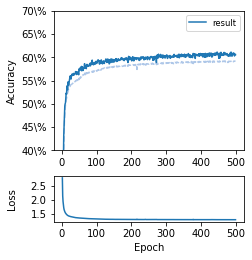

In [103]:
plot_model_comparison([history_resnet], 
                      ['result'],
                      figsize=(3.5,3.5),
                      axs=None,
                      ylim_acc=[40,70],
                      height_ratios=[1,0.33]);

Acc = 0.6009


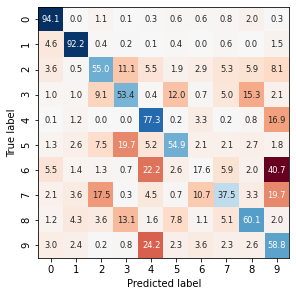

In [104]:
cf_matrix = calc_confusion_matrix_tf(model_res_N16, data_N16.x_test, data_N16.y_test)
fig = plot_confusion_matrix(cf_matrix);